In [1]:
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.layers import *
import pandas as pd
import numpy as np
from position import Position
import matplotlib.pyplot as plt
%matplotlib inline
import imp
# imp.reload(cnnfeat)
from multiprocessing import Queue
from multiprocessing import Manager, Process, Pool
import os
from time import time
import pickle
import bcolz
from tqdm import tqdm 
from cnnfeat import get_feats

Using TensorFlow backend.


Initializing Magics


In [2]:
from cycliclr import CyclicLR
from math import ceil

In [3]:
def conv_block(input_tensor, filters, kernel_size=(3,3), act=True, weight_decay=1e-6):
    # embed()
    x = Convolution2D(filters, kernel_size, strides=(1,1), padding='same', use_bias=False,
                      kernel_regularizer=l2(weight_decay))(input_tensor)
    x = BatchNormalization()(x)
    if act:
        x = Activation('relu')(x)
    return x

def res_block(input_tensor, filters):
    x = conv_block(input_tensor, filters)
    # x = conv_block(x, filters)
    x = conv_block(x, filters, act=False)
    x = keras.layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [4]:
from keras.layers import Input

# encoder
net_input = Input((8,8,14))
x = net_input
for i in range(2):
    x = res_block(x, 14)
x = conv_block(x, 2, kernel_size=(3,3))
for i in range(2):
    x = res_block(x, 2)
x = conv_block(x, 2, kernel_size=(3,3), act=False)
encoder_t = Activation('sigmoid', name='encoded')
encoded = encoder_t(x)
enc_shp = (8,8,2)

# decoder
x = encoded
for i in range(2):
    x = res_block(x, 2)
x = conv_block(x, 14, kernel_size=(3,3))
for i in range(2):
    x = res_block(x, 14)
x = conv_block(x, 14, kernel_size=(3,3), act=False)
decoder_t = Activation('sigmoid', name='decoded')
decoded = decoder_t(x)

# evaluator
x = encoded
x = Flatten()(x)
x = Dense(200)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(100)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)
value_t = Activation('tanh', name='value')
value = value_t(x)

dec_input = Input(enc_shp)
eval_input = Input(enc_shp)

encoder = Model(net_input, encoded) # 7.8k params
decoder = Model(dec_input, decoder_t(dec_input)) 
autoencoder = Model(net_input, decoded) # 17.5 params
evaluator = Model(net_input, value) # 50k params
train_model = Model(net_input, outputs=[decoded, value]) # 64k params

train_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 14)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 14)     1764        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8, 8, 14)     56          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 8, 8, 14)     0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
def batch_generator_df_bcolz(dframe, bcolz_arr, batch_size, shuffle=True, yielder=lambda x: x):
    assert(batch_size % bcolz_arr.chunklen == 0)
    chunks_per_batch = batch_size // bcolz_arr.chunklen
    init_bounds = bcolz_arr.partitions
    if bcolz_arr.leftover_elements > 0:
        init_bounds.append((init_bounds[-1][1], len(bcolz_arr)))
    while True:
        bounds = np.random.permutation(init_bounds) if shuffle else init_bounds
        feats_chunks, scores_chunks = [], []
        def return_batch():
            feats = np.concatenate(feats_chunks, axis=0)
            scores = np.concatenate(scores_chunks, axis=0)
            feats_chunks.clear()
            scores_chunks.clear()
            return yielder((feats, scores))
        chunks = 0
        for start, stop in bounds:
            feats_chunks.append(bcolz_arr[start:stop])
            scores_chunks.append(np.array(dframe[start:stop].score, dtype='float32'))
            chunks += 1
            if chunks % chunks_per_batch == 0:
                yield return_batch()
        if len(feats_chunks) > 0:
            yield return_batch()

In [6]:
from bcolz_array_iterator import BcolzArrayIterator

def batch_generator_bcolz(data, batch_size, shuffle=True):
    batch_generator_bcolz = BcolzArrayIterator(data, batch_size=batch_size, shuffle=shuffle)
    while True:
        feats = next(batch_generator_bcolz)
        yield feats, feats

In [7]:
def batch_generator_df(data, batch_size, shuffle=True):
    while True:
        data_ = data.sample(frac=1) if shuffle else data
        for iteration, batch in data_.groupby(np.arange(len(data)) // batch_size):
            fens = [f.strip() for f in batch.fen.tolist()]
            feats = np.stack([get_feats(Position.from_fen(fen)) for fen in fens])
            yield feats, feats

In [64]:
train_model.compile(keras.optimizers.SGD(lr=.01, momentum=.99, nesterov=True), 'mse', loss_weights=[1e-5, 1.])

In [45]:
features_sf3_sample = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3_sample.bc')
features_sf3_valid_sample = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3_valid_sample.bc')

In [46]:
sf_scores3 = pd.read_pickle('/ssd/slonik_data/sf_scores_3dep.pkl')

In [47]:
assert(np.allclose(features_sf3_valid_sample[0], get_feats(Position.from_fen(sf_scores3.iloc[-60000].fen))))
assert(np.allclose(features_sf3_sample[0], get_feats(Position.from_fen(sf_scores3.iloc[0].fen))))

In [86]:
wgts = train_model.get_weights()

In [78]:
train_model.set_weights(wgts)

In [114]:
batch_size = 1024
#nvalid = len(features_sf12_valid)

x = features_sf3_sample
x_valid = features_sf3_valid_sample

yielder = lambda f_s: (f_s[0], [f_s[0], f_s[1]]) # (feats, [feats, scores])
train_gen = batch_generator_df_bcolz(sf_scores3, x, batch_size, yielder=yielder)
valid_gen = batch_generator_df_bcolz(sf_scores3[-60000:], x_valid, batch_size, shuffle=False, yielder=yielder)

train_steps = ceil(len(x) / batch_size)
valid_steps = ceil(len(x_valid) / batch_size)

# lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint('../slonik_data/weights.{epoch:03d}-{val_loss:.6f}.h5', 
                                             monitor='val_loss', save_best_only=True, save_weights_only=True, period=1)
# stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')
clr = CyclicLR(base_lr=8e-4, max_lr=1e-2, step_size=train_steps*5, mode='triangular')
# clr = CyclicLR(base_lr=0, max_lr=1e-2, step_size=train_steps*5, mode='triangular')

callbacks = [clr]
# callbacks = [clr, checkpoint]
# K.set_value(train_model.optimizer.lr, 1e-3)
train_model.fit_generator(train_gen, train_steps, epochs=100, 
                          validation_data=valid_gen, validation_steps=valid_steps, callbacks=callbacks)

# K.set_value(train_model.optimizer.lr, 1e-5)
# train_model.fit_generator(train_gen, train_steps, epochs=2, validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0071 - decoded_loss: 0.2779 - value_loss: 0.0070 - val_loss: 0.0098 - val_decoded_loss: 0.2529 - val_value_loss: 0.0096
Epoch 2/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0070 - decoded_loss: 0.2779 - value_loss: 0.0069 - val_loss: 0.0107 - val_decoded_loss: 0.2573 - val_value_loss: 0.0106
Epoch 3/100
24/24 [==============================] - 1s 43ms/step - loss: 0.0067 - decoded_loss: 0.2780 - value_loss: 0.0066 - val_loss: 0.0112 - val_decoded_loss: 0.2613 - val_value_loss: 0.0111
Epoch 4/100
24/24 [==============================] - 1s 42ms/step - loss: 0.0064 - decoded_loss: 0.2781 - value_loss: 0.0063 - val_loss: 0.0085 - val_decoded_loss: 0.2649 - val_value_loss: 0.0083
Epoch 5/100
24/24 [==============================] - 1s 43ms/step - loss: 0.0062 - decoded_loss: 0.2782 - value_loss: 0.0060 - val_loss: 0.0077 - val_decoded_loss: 0.2683 - val_value_loss: 0.0075
Epoch 6/100
24/24 [=

Epoch 43/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0054 - decoded_loss: 0.2782 - value_loss: 0.0053 - val_loss: 0.0056 - val_decoded_loss: 0.2788 - val_value_loss: 0.0054
Epoch 44/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0054 - decoded_loss: 0.2782 - value_loss: 0.0053 - val_loss: 0.0056 - val_decoded_loss: 0.2788 - val_value_loss: 0.0054
Epoch 45/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0054 - decoded_loss: 0.2782 - value_loss: 0.0053 - val_loss: 0.0056 - val_decoded_loss: 0.2788 - val_value_loss: 0.0054
Epoch 46/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0054 - decoded_loss: 0.2782 - value_loss: 0.0053 - val_loss: 0.0056 - val_decoded_loss: 0.2788 - val_value_loss: 0.0054
Epoch 47/100
24/24 [==============================] - 1s 44ms/step - loss: 0.0054 - decoded_loss: 0.2782 - value_loss: 0.0052 - val_loss: 0.0056 - val_decoded_loss: 0.2788 - val_value_loss: 0.0054
Epoch 48/100
24

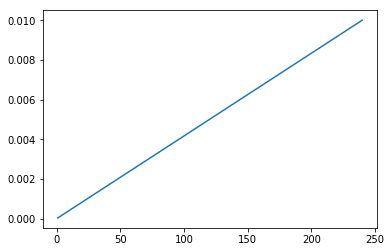

In [88]:
plt.plot(clr.history['iterations'], clr.history['lr'])

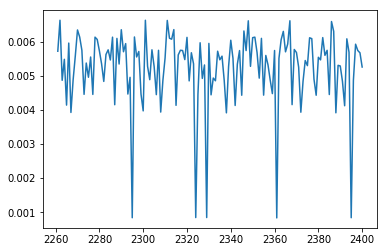

In [116]:
# rng = np.s_[-140:]
plt.plot(clr.history['iterations'][rng], clr.history['loss'][rng])

### evaluate models

In [85]:
batch_size = 1024 * 2
valid_steps = ceil(len(features_sf3_valid_sample) / batch_size)
valid_gen = batch_generator_df_bcolz(sf_scores3, features_sf3_valid_sample, batch_size, shuffle=False, 
                                     yielder=lambda f_s: (f_s[0], [f_s[0], f_s[1]]))
train_model.evaluate_generator(valid_gen, steps=valid_steps)
# train_model.metrics_names
# K.get_value(train_model.optimizer.lr)

[0.010914361697932085, 0.23725561400254566, 0.010763831712305546]

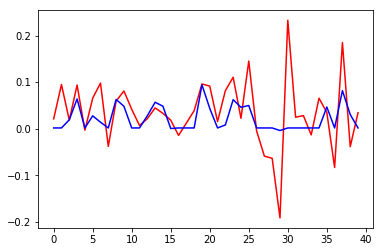

In [117]:
rng = slice(0,40)
dfrng = slice(rng.start+-60000, rng.stop+-60000)
fens = sf_scores3[dfrng].fen
scores = sf_scores3[dfrng].score
# np.allclose(features_sf12_valid[rng], np.array([get_feats(Position.from_fen(f)) for f in fens]))
# pprint(list(zip(scores, evaluator.predict(features_sf12_valid[rng]).squeeze())))
x = np.arange(len(scores))
plt.plot(x, scores, 'r')
plt.plot(x, train_model.predict(features_sf3_valid_sample[rng])[1].squeeze(), 'b')